https://www.learnopencv.com/install-dlib-on-ubuntu/ for dlib install

In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:
import dlib

In [4]:
detector = dlib.get_frontal_face_detector()

In [5]:
predictor = dlib.shape_predictor("/home/anjali/dlib-19.6/build/shape_predictor_68_face_landmarks.dat")

In [6]:
windowName = "Live Video Feed"
cv2.namedWindow(windowName)
video_capture = cv2.VideoCapture(0)
if video_capture.isOpened():
    ret, frame = video_capture.read()
else:
    ret = False

        
while ret:
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray)
    detections = detector(clahe_image, 1) #Detect the faces in the image
    for k,d in enumerate(detections): 
        shape = predictor(clahe_image, d) #Get coordinates
        for i in range(1,68): #There are 68 landmark points on each face
            cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2) 
    cv2.imshow("image", frame) 
    if cv2.waitKey(1) == 27:
           
        break
cv2.destroyAllWindows()    

video_capture.release()

In [7]:
import cv2
import glob
import random
import math
import numpy as np
import dlib
import itertools
from sklearn.svm import SVC

In [8]:
emotions = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"] #Emotion list

In [9]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/home/anjali/dlib-19.6/build/shape_predictor_68_face_landmarks.dat") 

In [10]:
clf = SVC(kernel='linear', probability=True, tol=1e-3)
data = {} 

In [11]:
def get_files(emotion): 
    files = glob.glob("dataset/%s/*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)]
    prediction = files[-int(len(files)*0.2):] 
    return training, prediction

In [12]:
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): 
        shape = predictor(image, d) 
        xlist = []
        ylist = []
        for i in range(1,68):
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        data['landmarks_vestorised'] = "error"

In [48]:
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        print(" working on %s" %emotion)
        training, prediction = get_files(emotion)
        
        for item in training:
            image = cv2.imread(item) 
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)

            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised'])
                training_labels.append(emotions.index(emotion))
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotions.index(emotion))
    return training_data, training_labels, prediction_data, prediction_labels

In [14]:
accur_lin = []

In [82]:
for i in range(0,2):
    print("Making sets %s" %i) 
    training_data, training_labels, prediction_data, prediction_labels = make_sets()
    npar_train = np.array(training_data) 
    npar_trainlabs = np.array(training_labels)
    print("training SVM linear %s" %i) 
    clf.fit(npar_train, training_labels)
    pred=clf.predict(npar_train)
    print(pred)
   
    npar_pred = np.array(prediction_data)
    print(prediction_labels)
    print(npar_pred)
    pred_lin = clf.score(npar_pred, prediction_labels)
    print ("linear: ", pred_lin)
    accur_lin.append(pred_lin) 
print("Mean value lin svm: %s" %np.mean(accur_lin))

Making sets 0
 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
 working on neutral
 working on sadness
 working on surprise
training SVM linear 0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

In [56]:
import matplotlib.pyplot as plt
def cam():
    cap = cv2.VideoCapture(0)
    
    if cap.isOpened():
        ret, frame = cap.read()
       
    else:
        ret = False

    img1 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
    
    plt.imshow(img1)
    plt.title('Color Image RGB')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

    cap.release()
    return img1

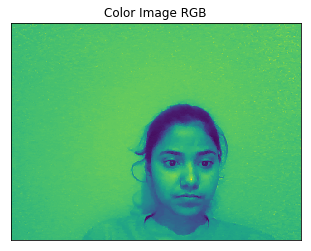

None


ValueError: could not convert string to float: '[ 313.          313.           90.81485649 -163.23581607  318.\n  335.           82.06246772 -177.07046412  323.          357.\n   78.98834759  166.97211276  331.          377.           78.63913961\n  151.26543352  345.          394.           77.61295637  135.07791099\n  362.          408.           78.58028091  118.88231033  381.\n  419.           82.02617499  103.36110598  401.          422.\n   82.81256094   89.27712838  420.          419.           82.28478548\n   75.90074153  435.          407.           76.32683618   62.6683115\n  447.          391.           69.97906475   47.75754784  456.\n  373.           65.45120738   31.09820082  463.          353.\n   64.53873726   12.35203155  467.          333.           67.33029044\n   -5.27837113  470.          311.           75.50611883  -21.92549441\n  470.          291.           85.02314494  -34.52976149  328.\n  278.           94.45773411 -139.62063247  340.          268.\n   93.07641354 -130.1020172   356.          266.           85.3781454\n -120.98608737  372.          270.           74.6277985  -111.99930321\n  387.          277.           63.5290105  -101.76664168  412.\n  276.           64.3316566   -79.20886211  426.          270.\n   73.93337629  -69.37355856  440.          266.           83.43230849\n  -61.31673656  455.          267.           90.78493996  -52.67607125\n  463.          278.           87.85984911  -44.14654599  401.\n  294.           45.20610458  -88.67569672  402.          309.\n   30.263188    -86.12577609  403.          324.           15.49610289\n  -78.66842197  404.          339.            4.0494273    -2.74640068\n  386.          351.           18.27920142  139.76913611  394.\n  352.           14.12294456  114.94007482  403.          354.\n   15.11580013   78.37940407  410.          352.           16.27545387\n   51.88999114  417.          350.           20.18151094   32.37369531\n  345.          295.           70.52084023 -141.19436754  355.\n  291.           65.90627184 -133.00862404  367.          292.\n   57.56147353 -124.92629731  377.          299.           46.28717251\n -119.73113196  366.          303.           49.62826841 -133.17203176\n  353.          302.           59.90149336 -141.61665768  419.\n  300.           43.57608832  -64.0844136   430.          293.\n   55.10514464  -56.95986799  441.          292.           62.54558418\n  -48.98642726  449.          296.           65.35376255  -41.37056696\n  442.          303.           55.47766213  -40.72334622  430.\n  303.           47.03930664  -50.30382961  369.          376.\n   48.09267433  130.06511469  383.          371.           36.04302088\n  118.0613217   395.          366.           27.26012251  100.47319793\n  401.          369.           29.82427558   87.99245711  409.\n  366.           28.29077607   71.3547573   418.          371.\n   36.56820589   60.43205544  430.          374.           45.97982308\n   49.19899198  419.          382.           46.85140956   66.01527175\n  410.          386.           47.87166562   77.88777584  402.\n  387.           47.84968016   87.5508148   394.          386.\n   47.18329718   97.25090635  383.          383.           46.97278614\n  111.15906913  374.          376.           45.03724109  125.19113051\n  394.          374.           35.31175795   99.70916512  401.\n  375.           35.82120958   88.32865073  409.          374.\n   35.96197343   75.43314842  425.          375.           43.69563261\n   55.02882279  409.          373.           34.9950224    75.02135974\n  402.          375.           35.86430827   86.73155255  395.\n  374.           35.15693106   98.10258277]'

In [83]:
#imgpath= "/home/anjali/Downloads/standard_test_images/lena_color_256.tif"
img3 = cam()


#gray1 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
clahe_image = clahe.apply(img3)
XY=get_landmarks(clahe_image)
print(XY)
X=np.array(data['landmarks_vectorised'])
#X=X.fillna(0.0,implace=True)
#X = X.replace('', 0)
from sklearn.preprocessing import Imputer

#X.reshape(-1, 1)
#y=format(X)
#print(y)
#imputer=Imputer(missing_values='\n',strategy='mean',axis=1)
#imputer=imputer.fit(y[:])
#y[:]=imputer.transform(y[:])



pred=clf.predict(y)
print(pred)